<h1>Second try with ADAM, 1129</h1>

<h1>In the previous experiments, using default ADAM params does not yield a better result than tuned SDG.</h1>
<h4>The performance issue with ADAM seems to be that the learning rate is too high.</h4>
<h4>I want to see how I can tune ADAM params so that the performance is the same or better than tuned SDG result.</h4>
<h2>Strategy:</h2>
<h3>1. Find optimal batch size for ADAM with default params</h3>
<h3>2. Experiment with ADAM decay</h3>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import numpy as np
import tensorflow as tf # changed to intel-optimized build
%load_ext tensorboard

tf.random.set_seed(42)
np.random.seed(42)

import shutil
import gc
import time
import datetime
import random
from winsound import Beep
from PIL import Image
import pickle
def beep():
    Beep(1000, 100)
    
beep()

In [5]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12,8]

In [ ]:
plt.plot([i for i in range(100)])

In [7]:
addr = r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env"
os.chdir(addr)

<h1>load super-expanded training data</h1>

In [8]:
with open('f_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)
beep()

# sample training data
n = len(train_x)
sn = int(n / 10)
np.random.seed(42)
index = np.random.choice([i for i in range(n)], size=sn, replace=False)

sub_tx, sub_ty = [], []

for ind in index:
    sub_tx.append(train_x[ind])
    sub_ty.append(train_y[ind])

sub_tx = np.array(sub_tx)
sub_ty = np.array(sub_ty)
sub_tx = sub_tx.reshape(np.shape(sub_tx)[0], np.shape(sub_tx)[1], np.shape(sub_tx)[2], 1)

beep()

gc.collect()

<h1>Build Network models</h1>

<h2>ADAM:</h2>

In [99]:
# def full_summary(layer):
#     #check if this layer has layers
#     if hasattr(layer, 'layers'):
#         print('summary for ' + layer.name)
#         layer.summary()
#         print('\n\n')
#         for l in layer.layers:
#             full_summary(l)

def build_adam_model(
    lmbda,
    n_eph,
    batch_size,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
    ):
    #############################################################
    tf.random.set_seed(42)
    #############################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    print('learning_rate= {}\n'.format(learning_rate))
    print('beta_1= {}\n'.format(beta_1))
    print('beta_2= {}\n'.format(beta_2))
    print('epsilon= {}\n'.format(epsilon))
    #############################################################
    
    model = tf.keras.models.Sequential()

    model.add(
        tf.keras.layers.Conv2D( # no padding
            32,
            (5,5),
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            ),
            input_shape=input_shape
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=(3,3), # following example of Kingma & Ba, arXiv:1412.6980v9
            strides=(2,2)
        )
    )

    model.add(
        tf.keras.layers.Conv2D( # no padding
            32,
            (5,5),
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=(2,2),
            strides=(2,2)
        )
    )

    model.add(
        tf.keras.layers.Flatten()
    )

    model.add(
        tf.keras.layers.Dense(
            1000,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )

    model.add(
        tf.keras.layers.Dense(
            10,
            activation=out_activation
        )
    )

    ################################################################
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
        amsgrad=amsgrad,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    return model
    
Beep(1000,100)


In [100]:

def train_cnn_adam( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        addr,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        input_shape=(28, 28, 1),
        hidden_activation=tf.nn.relu,
        out_activation=tf.nn.softmax
    ):
    ################################################################
    # build model
    ################################################################
    model = build_adam_model(
        lmbda,
        n_eph,
        batch_size,
        learning_rate = learning_rate,
        beta_1 = beta_1,
        beta_2 = beta_2,
        epsilon = epsilon,
        amsgrad = amsgrad,
        input_shape = input_shape,
        hidden_activation = hidden_activation,
        out_activation = out_activation,
        full_summaryQ = full_summaryQ
    )
    
    ################################################################
    #  set checkpoint
    ################################################################
    stamp = str(time.time()).replace('.', '_')
    print('\n\n\ntime stamp:', stamp + '\n\n\n')
    checkpoint_filepath = addr + '\{}'.format(stamp)
    print('checkpoint_filepath:',checkpoint_filepath)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    ################################################################
    ################################################################
    # summarize time and history
    print('total time:', te - ts)
    acc = history.history['accuracy']; print('\nacc', acc)
    loss = history.history['loss']; print('\nloss', loss)
    val_acc = history.history['val_accuracy']; print('\nval_acc', val_acc)
    val_loss = history.history['val_loss']; print('\nval_loss', val_loss)
    print()
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    model.load_weights(checkpoint_filepath)
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    
    ################################################################
    ################################################################
    #    visualize result
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, lmbda={}, {} epochs'.format(lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    gc.collect()
    Beep(1000, 100)


Beep(1000,100)


<h2>garbage collect</h2>

In [37]:
gc.collect()

0

<h1>1. Using default ADAM params, examine the relationship between short-term accuracy and mini-batch size</h1>
<h4>To save time, use sub-sampled training data</h4>

lmbda= 0.0001

n_eph= 20

batch_size= 5000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              289000    
__________

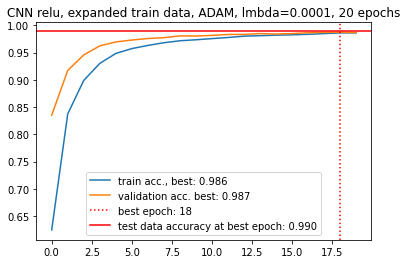

In [25]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 5000
n_eph = 20


train_cnn_adam(
    lmbda,
    batch_size,
    n_eph,
#     train_x,
#     train_y,
    sub_tx,
    sub_ty,
    val_x,
    val_y,
    test_x,
    test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
)

lmbda= 0.0001

n_eph= 20

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              289000    
__________

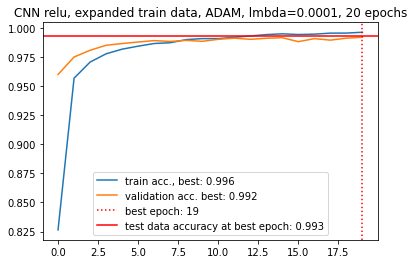

In [27]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 20


train_cnn_adam(
    lmbda,
    batch_size,
    n_eph,
#     train_x,
#     train_y,
    sub_tx,
    sub_ty,
    val_x,
    val_y,
    test_x,
    test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
)

lmbda= 0.0001

n_eph= 20

batch_size= 100

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              289000    
__________

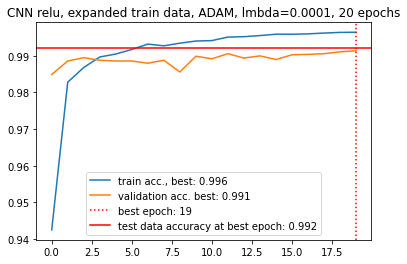

In [29]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 100
n_eph = 20


train_cnn_adam(
    lmbda,
    batch_size,
    n_eph,
#     train_x,
#     train_y,
    sub_tx,
    sub_ty,
    val_x,
    val_y,
    test_x,
    test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
)

lmbda= 0.0001

n_eph= 20

batch_size= 10

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1000)              289000    
___________

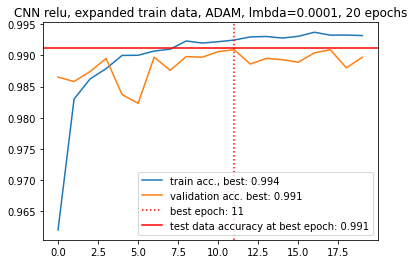

In [33]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 10
n_eph = 20


train_cnn_adam(
    lmbda,
    batch_size,
    n_eph,
#     train_x,
#     train_y,
    sub_tx,
    sub_ty,
    val_x,
    val_y,
    test_x,
    test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
)

<h4>calculation times seems to grow at log(steps)</h4>
<h4>found a good read: https://github.com/brethvoice/optuna_demo_MNIST</h4>

<h2>betch size = 1000 seems to be a good balancing point between accuracy and computation time.</h2>